In [ ]:
import requests
import pandas as pd
from time import sleep
from datetime import datetime, timedelta
import numpy as np
from scipy.stats import gamma, weibull_min, gumbel_r, logistic, lognorm, norm, shapiro, anderson_ksamp
from scipy import stats
from statsmodels.tools.eval_measures import aic
import warnings
warnings.filterwarnings("ignore")
import time
import random

# Below is the download of weather data - daily percipitation - from NOOA api

I use a list of stations that i researched to be in the area of corn growth and have data available with good consistency from 1970 to 2025.

The measure is "precipitation" which is defined as PRCP = Precipitation (tenths of mm)
desription from nooa : https://www.ncei.noaa.gov/pub/data/ghcn/daily/readme.txt

In [ ]:

TOKEN = 'YdOLteASIkmyqwPWBWGbcpclulckZAxj'
HEADERS = {'token': TOKEN}
URL = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"

stations = [
    "GHCND:USC00118740", "GHCND:USC00111280", "GHCND:USC00111290",
    "GHCND:USC00114013", "GHCND:USC00110072", "GHCND:USC00112931",
    "GHCND:USC00110445", "GHCND:USW00013802", "GHCND:USC00112931",
    "GHCND:USC00111577", "GHCND:USC00112736"
]

datatypeids = ["PRCP"]
start_year = 1969
end_year = 2025

# --- Simple global rate limiter (<= ~3 requests/sec) ---
MIN_INTERVAL = 0.34  # seconds between requests (~2.9 rps)
_last_call_ts = 0.0

def _respect_rate_limit():
    global _last_call_ts
    now = time.time()
    elapsed = now - _last_call_ts
    if elapsed < MIN_INTERVAL:
        time.sleep(MIN_INTERVAL - elapsed)
    _last_call_ts = time.time()

# --- Robust GET with retries/backoff for 429/5xx ---
def robust_get(session, url, headers=None, params=None,
               max_retries=6, base_delay=0.75, timeout=30):
    """
    Returns a (response, error_text). On success, error_text=None.
    Retries on 429/5xx with exponential backoff + jitter.
    Respects 'Retry-After' header when present.
    """
    attempt = 0
    while True:
        _respect_rate_limit()
        try:
            resp = session.get(url, headers=headers, params=params, timeout=timeout)
        except requests.RequestException as e:
            # network-level issue: backoff and retry
            if attempt >= max_retries:
                return None, f"Network error after retries: {e}"
            attempt += 1
            sleep_s = base_delay * (2 ** (attempt - 1)) + random.uniform(0, 0.3)
            time.sleep(sleep_s)
            continue

        # Success
        if resp.status_code == 200:
            return resp, None

        # Handle 429 Too Many Requests
        if resp.status_code == 429:
            # Respect Retry-After if present; otherwise exponential backoff
            retry_after = resp.headers.get("Retry-After")
            if retry_after is not None:
                try:
                    sleep_s = float(retry_after)
                except ValueError:
                    sleep_s = base_delay * (2 ** attempt)
            else:
                sleep_s = base_delay * (2 ** attempt) + random.uniform(0, 0.5)

            if attempt >= max_retries:
                return resp, f"429 rate limit after {max_retries} retries: {resp.text}"
            attempt += 1
            time.sleep(sleep_s)
            continue

        # Retry on 5xx
        if 500 <= resp.status_code < 600:
            if attempt >= max_retries:
                return resp, f"Server error {resp.status_code} after retries: {resp.text}"
            attempt += 1
            sleep_s = base_delay * (2 ** (attempt - 1)) + random.uniform(0, 0.5)
            time.sleep(sleep_s)
            continue

        # Other non-retryable status
        return resp, f"HTTP {resp.status_code}: {resp.text}"

# --- Main fetch loop ---
with requests.Session() as session:
    for station_id in stations:
        print(f"\nFetching data for {station_id}")
        all_data = []

        for year in range(start_year, end_year + 1):
            startdate = f"{year}-01-01"
            enddate = f"{year}-12-31"
            offset = 1
            print(f"  Year: {year}")

            while True:
                params = {
                    "datasetid": "GHCND",
                    "stationid": station_id,
                    "datatypeid": datatypeids,
                    "startdate": startdate,
                    "enddate": enddate,
                    "limit": 1000,
                    "offset": offset,
                    "units": "metric"
                }

                resp, err = robust_get(session, URL, headers=HEADERS, params=params)
                status_code = resp.status_code if resp is not None else "ERR"
                print(f"     Offset: {offset} | Status: {status_code}")

                if err is not None:
                    print(f"     Error fetching data: {err}")
                    # Break out of this year on unrecoverable/terminal error
                    break

                data = resp.json()
                results = data.get("results", [])

                if not results:
                    print(f"     No more data for {year} at offset {offset}")
                    break

                all_data.extend(results)

                # If we got fewer than limit, we reached the end for this year
                if len(results) < 1000:
                    break

                offset += 1000
                # Small pause between paginated pulls; still protected by global limiter
                time.sleep(0.05)

        # Save after finishing all years for this station
        if all_data:
            df = pd.DataFrame(all_data).drop_duplicates()
            file_name = f"{station_id.replace('GHCND:', '')}_1970_2025.csv"
            df.to_csv(file_name, index=False)
            print(f"✅ Saved {len(df)} records to {file_name}")
        else:
            print(f"⚠️ No data fetched for {station_id}")



Fetching data for GHCND:USC00118740
  Year: 1969
    🔄 Offset: 1 | Status: 200
  Year: 1970
    🔄 Offset: 1 | Status: 200
  Year: 1971
    🔄 Offset: 1 | Status: 200
  Year: 1972
    🔄 Offset: 1 | Status: 200
  Year: 1973
    🔄 Offset: 1 | Status: 200
  Year: 1974
    🔄 Offset: 1 | Status: 200
  Year: 1975
    🔄 Offset: 1 | Status: 200
  Year: 1976
    🔄 Offset: 1 | Status: 200
  Year: 1977
    🔄 Offset: 1 | Status: 200
  Year: 1978
    🔄 Offset: 1 | Status: 200
  Year: 1979
    🔄 Offset: 1 | Status: 200
  Year: 1980
    🔄 Offset: 1 | Status: 200
  Year: 1981
    🔄 Offset: 1 | Status: 200
  Year: 1982
    🔄 Offset: 1 | Status: 200
  Year: 1983
    🔄 Offset: 1 | Status: 200
  Year: 1984
    🔄 Offset: 1 | Status: 200
  Year: 1985
    🔄 Offset: 1 | Status: 200
  Year: 1986
    🔄 Offset: 1 | Status: 200
  Year: 1987
    🔄 Offset: 1 | Status: 200
  Year: 1988
    🔄 Offset: 1 | Status: 200
  Year: 1989
    🔄 Offset: 1 | Status: 200
  Year: 1990
    🔄 Offset: 1 | Status: 200
  Year: 1991
    

In [ ]:
#display statistics for data quality for all the stations
results = []

for station_id in stations:
    # Build filename
    file_name = f"{station_id.replace('GHCND:', '')}_1970_2025.csv"

    # Load CSV
    df = pd.read_csv(file_name, parse_dates=["date"])
    df = df.set_index("date").sort_index()

    # Generate full date range for 1970-2015
    full_range = pd.date_range("1970-01-01", "2025-07-31", freq="D")

    # Reindex to find missing dates
    df = df.reindex(full_range)

    # Count missing rows (any column missing)
    missing_days = df.isna().all(axis=1).sum()
    total_days = len(df)
    coverage_pct = 100 * (1 - missing_days / total_days)

    # Find first & last non-missing date (for any variable)
    first_available = df.dropna(how="all").index.min()
    last_available = df.dropna(how="all").index.max()

    results.append({
        "station": station_id,
        "coverage_%": round(coverage_pct, 2),
        "missing_days": missing_days,
        "total_days": total_days,
        "first_available_date": first_available.strftime("%Y-%m-%d") if pd.notnull(first_available) else None,
        "last_available_date": last_available.strftime("%Y-%m-%d") if pd.notnull(last_available) else None
    })

# Convert to DataFrame
coverage_df = pd.DataFrame(results)
print(coverage_df)

              station  coverage_%  missing_days  total_days  \
0   GHCND:USC00118740       99.84            32       20301   
1   GHCND:USC00111280       72.86          5510       20301   
2   GHCND:USC00111290       91.17          1792       20301   
3   GHCND:USC00114013       64.13          7281       20301   
4   GHCND:USC00110072       98.54           296       20301   
5   GHCND:USC00112931       98.71           261       20301   
6   GHCND:USC00110445       10.33         18203       20301   
7   GHCND:USW00013802       96.93           624       20301   
8   GHCND:USC00112931       98.71           261       20301   
9   GHCND:USC00111577       99.62            78       20301   
10  GHCND:USC00112736       96.61           688       20301   

   first_available_date last_available_date  
0            1970-01-01          2025-07-31  
1            1970-01-01          2022-10-07  
2            1970-01-01          2025-07-31  
3            1970-01-01          2009-06-30  
4            

In [ ]:
# Filter stations with full end date AND high coverage
full_end_df = coverage_df[
    (coverage_df["last_available_date"] == "2025-07-31") &
    (coverage_df["coverage_%"] > 95)
]

# Save station names as a list
best_stations = full_end_df["station"].tolist()

# Show results
print(full_end_df)
print("\n Best stations list:")
print(best_stations)

              station  coverage_%  missing_days  total_days  \
0   GHCND:USC00118740       99.84            32       20301   
4   GHCND:USC00110072       98.54           296       20301   
5   GHCND:USC00112931       98.71           261       20301   
8   GHCND:USC00112931       98.71           261       20301   
9   GHCND:USC00111577       99.62            78       20301   
10  GHCND:USC00112736       96.61           688       20301   

   first_available_date last_available_date  
0            1970-01-01          2025-07-31  
4            1970-01-01          2025-07-31  
5            1970-01-01          2025-07-31  
8            1970-01-01          2025-07-31  
9            1970-01-01          2025-07-31  
10           1970-01-01          2025-07-31  

 Best stations list:
['GHCND:USC00118740', 'GHCND:USC00110072', 'GHCND:USC00112931', 'GHCND:USC00112931', 'GHCND:USC00111577', 'GHCND:USC00112736']


Below i aggregate the stations data into one singe data point for the state of Illinois where the corn is grown. I have 6 stations in total from which I take the data. I average the percipitation across those to get the avg_percipitation value. In the end I have to see if despite doing that there are still any missing values (there aren't). After that I also aggregate the avg_perc variable into a weekly umber by just summing up the daily data over the week.

In [ ]:

# Base daily index
base_range = pd.date_range("1970-01-01", "2025-07-31", freq="D")

# Helper to load and align a single station file
def load_station(station_id):
    """
    station_id: e.g. 'GHCND:USC00118740'
    Returns a DataFrame with one column named after the station,
    indexed by the base_range to get also the dates that are missing.
    """
    file_name = f"{station_id.replace('GHCND:', '')}_1970_2025.csv"
    df = pd.read_csv(file_name, usecols=["date", "value"], parse_dates=["date"])
    df = (
        df.set_index("date")
          .sort_index()
          .rename(columns={"value": station_id})
          .reindex(base_range)  # align to full base timeline
    )
    return df

# Load and merge all best stations
station_dfs = [load_station(st) for st in best_stations]
combined = pd.concat(station_dfs, axis=1)

# Average row-wise ignoring NaNs
combined["avg_precip"] = combined.mean(axis=1, skipna=True)

#count missing days too see if we need to adjust the df for missing values
missing_dates = base_range.difference(combined.index)

# Show results
print(f"Total missing dates: {len(missing_dates)}")
print(missing_dates)

# If all stations are missing on a day, carry forward previous day's average
if missing_dates != 0:
  combined["avg_precip"] = combined["avg_precip"].ffill()

# Final DataFrame
weather_data = combined[["avg_precip"]].reset_index().rename(columns={"index": "date"})

# Optional: save
weather_data.to_csv("weather_data.csv", index=False)




Total missing dates: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [ ]:
# --------------------
# 1. Load precipitation data
# --------------------
#weather_data = pd.read_csv("weather_data.csv", parse_dates=["date"])

# Ensure daily frequency
weather_data = weather_data.set_index("date").sort_index().asfreq("D")

# --------------------
# 2. Aggregate to weekly totals
# --------------------
weekly_precip = weather_data.resample("W-SUN").sum(min_count=7)  # weekly total, Sunday end
weekly_precip = weekly_precip.rename(columns={"avg_precip": "weekly_precip"})

# --------------------
# 3. Compute rolling 6-month (≈ 26 weeks) precipitation
# --------------------
weekly_precip["precip_6mo"] = weekly_precip["weekly_precip"].rolling(window=26, min_periods=26).sum()

# Drop initial weeks with insufficient history
weekly_precip = weekly_precip.dropna(subset=["precip_6mo"])



One problem that occurs is that in some years there are 53 weeks. This occurs 10 times in the 55 years - but this means that the sample for SPI formation for iso week 53 is not big enough to form a viable distribution for most cases. Thus we force the week 53 into week 52 - this means week 53 contribues to week 52 distribution and SPI for week 53 is modeled by that distribution. Since the weeks are one after the other this shouldnt pose that big of an an+djustment.

In [ ]:
# === Helper: Force ISO week 53 into week 52 ===
import pandas as pd
import numpy as np

def add_iso_cols_inplace(df, date_col=None, year_col="iso_year", week_col="iso_week"):
    """
    Adds/overwrites ISO year/week columns.
    - If date_col is None: uses the DataFrame's DatetimeIndex
    - Else: uses df[date_col] (converted to datetime)
    """
    if date_col is None:
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("date_col=None requires a DatetimeIndex.")
        iso = df.index.isocalendar()
    else:
        df[date_col] = pd.to_datetime(df[date_col])
        iso = df[date_col].dt.isocalendar()

    # Works across pandas versions (attrs vs. dict-like)
    df[year_col] = getattr(iso, "year", iso["year"]).astype(int)
    df[week_col] = getattr(iso, "week", iso["week"]).astype(int)
    return df

def force_week53_inplace(df, week_col="iso_week"):
    """Forces ISO week 53 → 52 in-place."""
    if week_col not in df.columns:
        raise KeyError(f"'{week_col}' not found; call add_iso_cols_inplace(...) first.")
    df.loc[df[week_col] == 53, week_col] = 52
    return df

In [ ]:
weekly_precip = weekly_precip.sort_index()

# 1) Add ISO year/week once
add_iso_cols_inplace(weekly_precip, date_col=None)
count_53 = (weekly_precip["iso_week"] == 53).sum()
print(f"ISO 53 week count: {count_53}")
# 2) Normalize weeks (53 -> 52)
force_week53_inplace(weekly_precip)
#
# Sanity check
print(weekly_precip[["iso_year","iso_week"]].head())
#assert (weekly_precip["iso_week"] == 53).sum() == 0 - no error if we comment this out so its unneccessary for our code

ISO 53 week count: 10
            iso_year  iso_week
date                          
1970-07-05      1970        27
1970-07-12      1970        28
1970-07-19      1970        29
1970-07-26      1970        30
1970-08-02      1970        31


In [ ]:
count_53 = (weekly_precip["iso_week"] == 53).sum()
print(f"ISO 53 week count after adjustment to 52 week: {count_53}")

ISO 53 week count after adjustment to 52 week: 0


Next we need to see if there are many weeks in the data set that have zero percipitation as this can affect fitting of the distribution for SPI. Proble because Gamma/Weibull are continuous distributions on (0, ∞) and have no probability mass at exactly 0. Adding epislon to 0 not a good solution because it breaks continuity in the distribution. Better to adjust for the zero mass.

In [ ]:
#count number of weeks with zero precipitation - this is important in SPI calculation because of disctributions
zero_count = (weekly_precip["weekly_precip"] == 0).sum()
print(f"Number of weeks with zero precipitation: {zero_count}")
zero_pct = (weekly_precip["weekly_precip"] == 0).mean() * 100
print(f"Percentage of weeks with zero precipitation: {zero_pct:.2f}%")

Number of weeks with zero precipitation: 51
Percentage of weeks with zero precipitation: 1.77%


In [ ]:
# ================================
# Force the "most wins" distribution globally, refit params over time (no look-ahead)
# ================================

candidate_distributions = {
    "gamma":   stats.gamma,
    "weibull": stats.weibull_min,
    "lognorm": stats.lognorm,
    "gumbel":  stats.gumbel_r,
    "logistic":stats.logistic,
    "norm":    stats.norm
}

# Reference period used to count "wins" per week-of-year
ref_start, ref_end = 1970, 1990

# Fitting controls
MIN_SAMPLES  = 20        # minimum positive samples needed to fit
WINDOW_YEARS = 30      # None = expanding history; set e.g. 30 for trailing 30-yr window according to WMO standards

# --- prep ---
weekly_precip = weekly_precip.sort_index().copy()
iso = weekly_precip.index.isocalendar()
weekly_precip["iso_year"] = iso.year.astype(int)
weekly_precip["iso_week"] = iso.week.clip(upper=52).astype(int)
print(weekly_precip.head(605))
# --------------------------------
# A) Count wins per ISO week on the reference period
# --------------------------------
ref_df = weekly_precip[
    (weekly_precip.index.year >= ref_start) &
    (weekly_precip.index.year <= ref_end)
].copy()

win_counts = {name: 0 for name in candidate_distributions.keys()}

for wk in sorted(ref_df["iso_week"].unique()):
    x_all = ref_df.loc[ref_df["iso_week"] == wk, "precip_6mo"]
    x_pos = x_all[x_all > 0].values
    if len(x_pos) < MIN_SAMPLES:
        continue

    best_name, best_aic = None, np.inf
    for name, dist in candidate_distributions.items():
        try:
            params = dist.fit(x_pos)
            ll = np.sum(dist.logpdf(x_pos, *params))
            this_aic = aic(ll, len(params), len(x_pos))
            if this_aic < best_aic:
                best_aic = this_aic
                best_name = name
        except Exception:
            pass

    if best_name is not None:
        win_counts[best_name] += 1

# Pick overall winner = most wins across weeks
if all(v == 0 for v in win_counts.values()):
    raise RuntimeError("No distribution won any week in the reference period. Check data coverage.")

overall_best = max(win_counts, key=win_counts.get)
print("=== Weekly winners on reference period ===")
for k, v in sorted(win_counts.items(), key=lambda kv: kv[1], reverse=True):
    print(f"{k:9s}: {v} wins")
print(f"\n🏆 Forcing distribution family globally: {overall_best}")

chosen_dist = candidate_distributions[overall_best]



            weekly_precip  precip_6mo  iso_year  iso_week
date                                                     
1970-07-05      29.633333  554.183333      1970        27
1970-07-12       2.766667  555.350000      1970        28
1970-07-19      23.783333  572.083333      1970        29
1970-07-26       7.066667  576.266667      1970        30
1970-08-02      27.283333  596.383333      1970        31
...                   ...         ...       ...       ...
1982-01-03      25.850000  500.476667      1981        52
1982-01-10      12.016667  506.576667      1982         1
1982-01-17       8.013333  473.423333      1982         2
1982-01-24      21.533333  467.940000      1982         3
1982-01-31      49.553333  485.893333      1982         4

[605 rows x 4 columns]
=== Weekly winners on reference period ===
weibull  : 48 wins
logistic : 2 wins
gamma    : 1 wins
lognorm  : 1 wins
gumbel   : 0 wins
norm     : 0 wins

🏆 Forcing distribution family globally: weibull


**For now I still fit the SPI according to gamma distribution, even though the calc shows weibull is the best because I'm worried about look ahead bias here - can i use weibull?**

I set the period for which SPI is averaged and compared to to 30 years to account for differing weather patterns that can appear. The results are quite robust to setting lookback period to None as well (meaning it always takes full sample)

In [ ]:
from scipy.stats import gamma as gamma_dist, norm
# --------------------
# Config
# --------------------
MIN_SAMPLES  = 10   # minimum positive samples required to fit
WINDOW_YEARS = 30   # None = expanding history; else trailing N years (e.g., 30)

# --------------------
# Prep: chronological order + ISO week (no 53->52 forcing here)
# --------------------
weekly_precip = weekly_precip.sort_index().copy()
if "iso_week" not in weekly_precip.columns:
    weekly_precip["iso_week"] = weekly_precip.index.isocalendar().week.astype(int)

t_ref = weekly_precip.index
spi_values = []

# --------------------
# SPI-6 (Gamma, zero-inflated, no look-ahead)
# --------------------
for idx in weekly_precip.index:
    wk  = int(weekly_precip.at[idx, "iso_week"])
    val = weekly_precip.at[idx, "precip_6mo"]
    t_now = idx

    # Past-only reference for the SAME ISO week
    mask = (t_ref < t_now) & (weekly_precip["iso_week"] == wk)
    if WINDOW_YEARS is not None:
        start_cut = t_now - pd.DateOffset(years=WINDOW_YEARS)
        mask &= (t_ref >= start_cut)

    ref_all = weekly_precip.loc[mask, "precip_6mo"]     # includes zeros for zero-mass estimate
    x_pos   = ref_all[ref_all > 0].values               # fit only on strictly positive values

    # Need enough positive samples to fit Gamma
    if len(x_pos) < MIN_SAMPLES:
        spi_values.append(np.nan)
        continue

    # Fit Gamma on positive support (force loc=0)
    try:
        params = gamma_dist.fit(x_pos, floc=0)          # (shape, loc=0, scale)
    except Exception:
        spi_values.append(np.nan)
        continue

    # Zero mass with small smoothing (plotting position)
    n_ref = len(ref_all)
    if n_ref == 0:
        spi_values.append(np.nan)
        continue
    p0 = (np.sum(ref_all.values <= 0) + 1) / (2 * (n_ref + 1))

    # Zero-inflated CDF -> SPI
    if pd.isna(val):
        spi = np.nan
    elif val <= 0:
        cdf = p0
        cdf = float(np.clip(cdf, 1e-6, 1 - 1e-6))
        spi = norm.ppf(cdf)
    else:
        cdf_pos = gamma_dist.cdf(val, *params)
        cdf = p0 + (1 - p0) * cdf_pos
        cdf = float(np.clip(cdf, 1e-6, 1 - 1e-6))
        spi = norm.ppf(cdf)

    spi_values.append(spi)

weekly_precip["SPI_6"] = spi_values

# --------------------
# Output
# --------------------
spi_6_df = (
    weekly_precip[["weekly_precip", "precip_6mo", "SPI_6"]]
    .reset_index()
    .rename(columns={"index": "date"})
)
spi_6_df.to_csv("weekly_spi6_gamma_only.csv", index=False)
print("✅ Weekly SPI-6 (Gamma, zero-inflated, no look-ahead) saved to 'weekly_spi6_gamma_only.csv'")



✅ Weekly SPI-6 (Gamma, zero-inflated, no look-ahead) saved to 'weekly_spi6_gamma_only.csv'


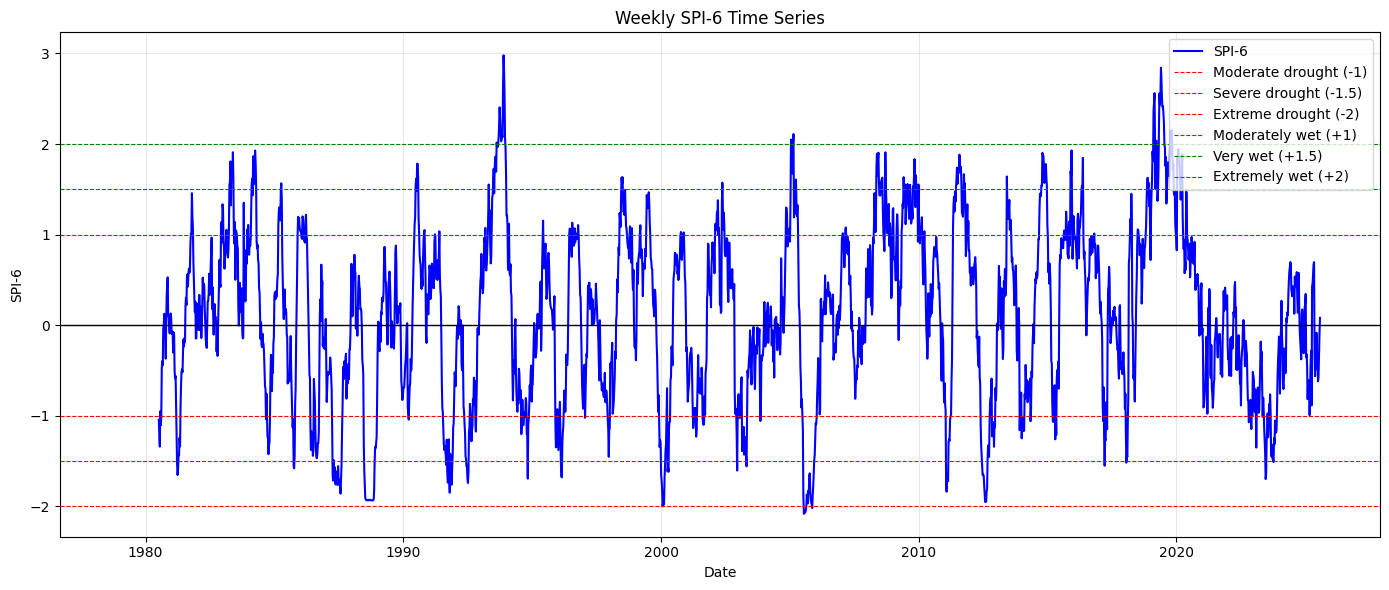

In [ ]:
import matplotlib.pyplot as plt

# Assume spi_6_df has columns: ['date', 'weekly_precip', 'precip_6mo', 'SPI_6']

plt.figure(figsize=(14,6))
plt.plot(spi_6_df["date"], spi_6_df["SPI_6"], label="SPI-6", color="blue")

# Add zero line for reference
plt.axhline(0, color="black", linewidth=1)

# Optional drought category thresholds
plt.axhline(-1, color="red", linestyle="--", linewidth=0.8, label="Moderate drought (-1)")
plt.axhline(-1.5, color="red", linestyle="--", linewidth=0.8, label="Severe drought (-1.5)")
plt.axhline(-2, color="red", linestyle="--", linewidth=0.8, label="Extreme drought (-2)")

plt.axhline(1, color="green", linestyle="--", linewidth=0.8, label="Moderately wet (+1)")
plt.axhline(1.5, color="green", linestyle="--", linewidth=0.8, label="Very wet (+1.5)")
plt.axhline(2, color="green", linestyle="--", linewidth=0.8, label="Extremely wet (+2)")

plt.title("Weekly SPI-6 Time Series")
plt.xlabel("Date")
plt.ylabel("SPI-6")
plt.legend(loc="upper right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Next we do a sanity check for distr of SPI. It is not gaussian according ti the Shapiro–Wilk test, but it looks fairly Gaussian on the histogram. McKee et al. (1993) and many later SPI studies do not require strict Gaussianity after transformation. ---- so good enough?

Statistic=nan, p=nan
Reject H0: data does not look Gaussian


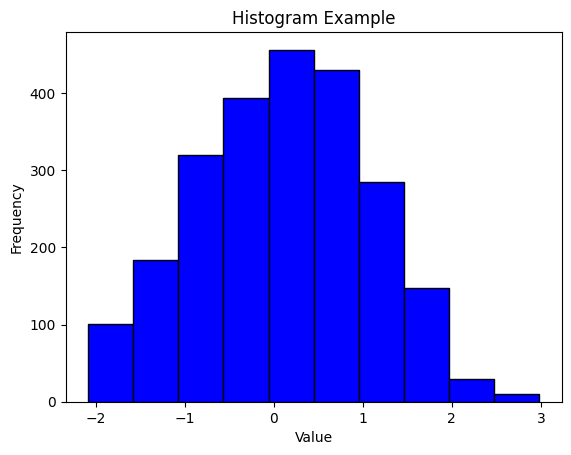

In [ ]:
from scipy.stats import shapiro

stat, p = shapiro(spi_6_df["SPI_6"])
print("Statistic=%.3f, p=%.3f" % (stat, p))

if p > 0.05:
    print("Fail to reject H0: data looks Gaussian (normal)")
else:
    print("Reject H0: data does not look Gaussian")

# Create histogram
plt.hist(spi_6_df["SPI_6"], bins=10, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Example')

# Show plot
plt.show()



According to the above graph one issue that I can see is that it seems that the SPI patter is slightly different in the last 5 years which are exactly the years we are predicting. The weather was not so extreme as other years. It was only slightly dry or wet.

Next I check if there are any SPI at extreme values - the probability of such a value is at 0.1%. This is to check if there are any very unlikely SPI values appearing.

In [ ]:
from scipy.stats import norm
import numpy as np

P_FLOOR = 0.001  # 0.1% practical floor

violations = []
floors_out = []

for idx in weekly_precip.index:
    wk = int(weekly_precip.at[idx, "iso_week"])
    # past-only pool
    mask = (weekly_precip.index < idx) & (weekly_precip["iso_week"] == wk)
    ref_vals = weekly_precip.loc[mask, "precip_6mo"].dropna().values
    if len(ref_vals) == 0 or not np.isfinite(weekly_precip.at[idx, "SPI_6"]):
        continue

    # practical SPI floor = Φ^{-1}(p_floor)
    spi_floor = norm.ppf(P_FLOOR)

    floors_out.append({
        "date": idx,
        "spi_floor_practical": spi_floor,
        "spi_now": weekly_precip.at[idx, "SPI_6"],
        "precip_6mo": weekly_precip.at[idx, "precip_6mo"],
        "weekly_precip": weekly_precip.at[idx, "weekly_precip"],
    })

    if weekly_precip.at[idx, "SPI_6"] < spi_floor - 1e-6:
        violations.append(floors_out[-1])

floors_df = pd.DataFrame(floors_out)
viol_df   = pd.DataFrame(violations)

print(f"\nWeeks where SPI < practical floor (p={P_FLOOR}): {len(viol_df)}")
if not viol_df.empty:
    print(viol_df.head(10).to_string(index=False))



Weeks where SPI < practical floor (p=0.001): 0


Next we check if there are any dates for which SPI could not be calc. Any NaN values for SPI.

In [ ]:
# =========================
# Inspect NaN SPI values
# =========================

# Count total NaNs in the SPI column
n_nans = spi_6_df["SPI_6"].isna().sum()
print(f"Total NaN values in SPI_6: {n_nans}")

# Extract all rows where SPI_6 is NaN
nan_rows = spi_6_df[spi_6_df["SPI_6"].isna()].copy()

# Display first few rows for quick check
print(nan_rows.head())

# Optionally: convert to list of dicts so you can view them easily
nan_rows_list = nan_rows.to_dict(orient="records")

# Example: print first problematic case in detail
if nan_rows_list:
    print("\nExample problematic row with NaN SPI:")
    for k, v in nan_rows_list[0].items():
        print(f"{k}: {v}")

# Save to CSV if you want to review all later
# nan_rows.to_csv("nan_spi_cases.csv", index=False)


Total NaN values in SPI_6: 520
        date  weekly_precip  precip_6mo  SPI_6
0 1970-07-05      29.633333  554.183333    NaN
1 1970-07-12       2.766667  555.350000    NaN
2 1970-07-19      23.783333  572.083333    NaN
3 1970-07-26       7.066667  576.266667    NaN
4 1970-08-02      27.283333  596.383333    NaN

Example problematic row with NaN SPI:
date: 1970-07-05 00:00:00
weekly_precip: 29.633333333333333
precip_6mo: 554.1833333333334
SPI_6: nan


In [ ]:
nan_rows = []

for idx in weekly_precip.index:
    wk = int(weekly_precip.at[idx, "iso_week"])
    val = weekly_precip.at[idx, "precip_6mo"]

    mask = (weekly_precip.index < idx) & (weekly_precip["iso_week"] == wk)
    ref_all = weekly_precip.loc[mask, "precip_6mo"]
    x_pos   = ref_all[ref_all > 0].values

    if len(x_pos) < MIN_SAMPLES:
        nan_rows.append((idx, "Too few samples", wk, len(x_pos)))
        continue

    try:
        params = chosen_dist.fit(x_pos)
    except Exception as e:
        nan_rows.append((idx, f"Fit failed: {e}", wk, len(x_pos)))
        continue


We can expect thta the rows up to mid 1980 will be Nan because there is not enough samples to fit the distribution. There are no Nan rows for SPI after that date.

In [ ]:
nan_rows

[(Timestamp('1970-07-05 00:00:00'), 'Too few samples', 27, 0),
 (Timestamp('1970-07-12 00:00:00'), 'Too few samples', 28, 0),
 (Timestamp('1970-07-19 00:00:00'), 'Too few samples', 29, 0),
 (Timestamp('1970-07-26 00:00:00'), 'Too few samples', 30, 0),
 (Timestamp('1970-08-02 00:00:00'), 'Too few samples', 31, 0),
 (Timestamp('1970-08-09 00:00:00'), 'Too few samples', 32, 0),
 (Timestamp('1970-08-16 00:00:00'), 'Too few samples', 33, 0),
 (Timestamp('1970-08-23 00:00:00'), 'Too few samples', 34, 0),
 (Timestamp('1970-08-30 00:00:00'), 'Too few samples', 35, 0),
 (Timestamp('1970-09-06 00:00:00'), 'Too few samples', 36, 0),
 (Timestamp('1970-09-13 00:00:00'), 'Too few samples', 37, 0),
 (Timestamp('1970-09-20 00:00:00'), 'Too few samples', 38, 0),
 (Timestamp('1970-09-27 00:00:00'), 'Too few samples', 39, 0),
 (Timestamp('1970-10-04 00:00:00'), 'Too few samples', 40, 0),
 (Timestamp('1970-10-11 00:00:00'), 'Too few samples', 41, 0),
 (Timestamp('1970-10-18 00:00:00'), 'Too few samples', 